In [1]:
from d2l import torch as d2l
import torchvision
import torch
import os
%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# #@save
# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
#                            '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

# voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
voc_dir = '../data/VOCdevkit/VOC2012/'

### ImageSets/Segmentation存储用于训练和测试样本的文件名
### JPEG存储输入图像 SegmentationClass存储标签

In [3]:
#@save
def read_voc_images(voc_dir, is_train=True):
    """"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation', 
                            'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

In [4]:
len(train_features), len(train_labels), train_features[0].shape

(1464, 1464, torch.Size([3, 281, 500]))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

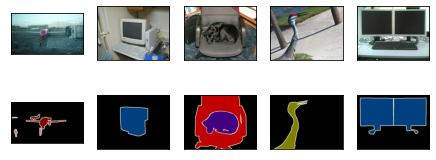

In [5]:
# 绘制训练集的前五个图片和其标签
n = 5
imgs = train_features[0: n] + train_labels[0: n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)

In [6]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [7]:
#@save
def voc_colormap2label():
    """"""
    # 将 0 [0, 0, 0] 映射成 colormap2label[0 * 256 * 256 + 0 * 256 + 0] = 0
    # 将 1 [128, 0, 0] 映射成 colormap2label[128 * 256 * 256 + 0 * 256 + 0] = 1
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    # colormap[:, :, 0] 图片第一个通道 R  colormap[:, :, 1] 第二个通道G  colormap[:, :, 3] B
    # idx 感觉像是将三通道 融合成一个通道
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    # 我觉得可以这么写
    # colormap = colormap.numpy().astype('int32')
    # idx = ((colormap[0, :, :] * 256 + colormap[1, :, :]) * 256 + colormap[2, :, :]) 
    return colormap2label[idx]

In [8]:
# 验证一下
colormap2label = voc_colormap2label()
# 分别对应 1 和 3
colormap2label[128 * 256 * 256], colormap2label[128 * 256 * 256 + 128 * 256]

(tensor(1), tensor(3))

In [9]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

In [10]:
colormap = torch.tensor(train_labels[0], dtype=torch.long)[:, 105:115, 130:140]
idx = ((colormap[0, :, :] * 256 + colormap[1, :, :]) * 256 + colormap[2, :, :]) 
colormap2label[idx]

C:\Users\36141\AppData\Local\Temp\ipykernel_26628\16395294.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colormap = torch.tensor(train_labels[0], dtype=torch.long)[:, 105:115, 130:140]


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [11]:
c = train_labels[0].permute(1, 2, 0).numpy().astype('int32')[105:115, 130:140, :]
c

array([[[  0,   0,   0],
        [  0,   0,   0],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [128,   0,   0]],

       [[  0,   0,   0],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[  0,   0,   0],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [224, 224, 192],
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        [128,   0, 

In [12]:
idx = (c[:, :, 0] * 256 + c[:, :, 1]) * 256 + c[:, :, 2]
idx

array([[       0,        0, 14737600, 14737600, 14737600, 14737600,
        14737600, 14737600, 14737600,  8388608],
       [       0, 14737600, 14737600, 14737600, 14737600, 14737600,
        14737600,  8388608,  8388608,  8388608],
       [       0, 14737600, 14737600, 14737600, 14737600, 14737600,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600,  8388608,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [       0, 14737600, 14737600, 14737600, 14737600, 147376

In [13]:
color = train_labels[0].numpy().astype('int32')[:, 105:115, 130:140]
((color[0, :, :] * 256 + color[1, :, :]) * 256 + color[2, :, :])

array([[       0,        0, 14737600, 14737600, 14737600, 14737600,
        14737600, 14737600, 14737600,  8388608],
       [       0, 14737600, 14737600, 14737600, 14737600, 14737600,
        14737600,  8388608,  8388608,  8388608],
       [       0, 14737600, 14737600, 14737600, 14737600, 14737600,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600,  8388608,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [14737600, 14737600, 14737600, 14737600, 14737600,  8388608,
         8388608,  8388608,  8388608,  8388608],
       [       0, 14737600, 14737600, 14737600, 14737600, 147376

In [14]:
train_labels[0][:, 105:115, 130:140]

tensor([[[  0,   0, 224, 224, 224, 224, 224, 224, 224, 128],
         [  0, 224, 224, 224, 224, 224, 224, 128, 128, 128],
         [  0, 224, 224, 224, 224, 224, 128, 128, 128, 128],
         [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
         [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
         [224, 224, 224, 224, 128, 128, 128, 128, 128, 128],
         [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
         [224, 224, 224, 224, 224, 128, 128, 128, 128, 128],
         [  0, 224, 224, 224, 224, 224, 128, 128, 128, 128],
         [  0, 224, 224, 224, 224, 224, 224, 224, 128, 128]],

        [[  0,   0, 224, 224, 224, 224, 224, 224, 224,   0],
         [  0, 224, 224, 224, 224, 224, 224,   0,   0,   0],
         [  0, 224, 224, 224, 224, 224,   0,   0,   0,   0],
         [224, 224, 224, 224, 224,   0,   0,   0,   0,   0],
         [224, 224, 224, 224, 224,   0,   0,   0,   0,   0],
         [224, 224, 224, 224,   0,   0,   0,   0,   0,   0],
         [224, 224, 22

### 语义分割的时候如果要切割图片要将图片与标签一一对应起来   也就是说裁的位置得一样

In [15]:
#@save
def voc_rand_crop(feature, label, height, width):
    rect = torchvision.transforms.RandomCrop.get_params(img=feature, output_size=(height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

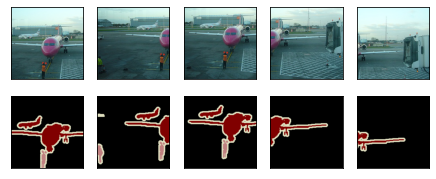

In [16]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 200)
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[0::2] + imgs[1::2], 2, n)

In [17]:
#@save
class VOCSegDataset(torch.utils.data.Dataset):
    
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print(f'read {len(self.features)} examples')
    
    def normalize_image(self, img):
        return self.transform(img.float() / 255)
        
    def filter(self, imgs):
        """只保留图片大小大于想要裁剪的大小的图片"""
        return [img for img in imgs
               if (img.shape[1] >= self.crop_size[0] and img.shape[2] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        """读取单个样本和标签"""
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
        
    
    def __len__(self):
        return len(self.features)

In [18]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


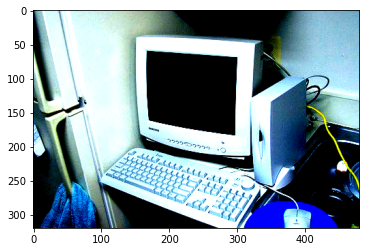

In [19]:
from matplotlib import pyplot as plt
import numpy as np
img = torchvision.utils.make_grid(voc_train[0][0]).numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [20]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, 
                                         shuffle=True, drop_last=True)

In [21]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


In [22]:
# 整合所有组件
# @save
def load_data_voc(batch_size, crop_size):
    voc_dir = '../data/VOCdevkit/VOC2012/'
    # d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir),
        batch_size, shuffle=True, drop_last=True
    )
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir),
        batch_size, drop_last=True
    )
    return train_iter, test_iter